###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 parts of this notebook are from ([this Jupyter notebook](https://nbviewer.jupyter.org/github/krischer/seismo_live/blob/master/notebooks/Computational%20Seismology/Wave%20Propagation%20%26%20Analytical%20Solutions/Greens_function_acoustic_1-3D.ipynb)) by Kristina Garina, Ashim Rijal and Heiner Igel ([@heinerigel](https://github.com/heinerigel)) which is a supplemenatry material to the book [Computational Seismology: A Practical Introduction](http://www.computational-seismology.org/),  additional modifications by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

###### Translated by Huizhe Di @ SCSIO

# 三维和一维声学介质中的雷暴

<img src="data/800px-Lightning_cloud_to_cloud.jpg" style="width: 800px;"/>

在上节课中, 我们导出了均匀声学一维、二维和三维介质的格林函数解。通过将格林函数与已知的震源小波进行卷积，我们可以计算任意偏移距处的地震图. 

在上一个笔记本的玩具例子说明了基本概念，然而介质参数的p波速度为1米/秒是物理上不现实的。至少我从未见过用脚就能跑得过的地震波。

在这个笔记本中，我想用一个比较现实的例子，分别计算雷电在均匀的三维和一维声大气中的波传播。这个例子说明了一维介质近似的缺点。

In [1]:
# Import Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.io.wavfile import read # read wav audio files
from IPython.display import Audio # play audio file in Jupyter notebook

首先，我们需要估计一个真实的震源小波来模拟雷声的传播。最简单的解决方案是从波文件导入小波到numpy数组。波文件可以使用 `read` 函数从 `scipy.io.wavfile`. 除了看到结果波形, 我们也可以听它们. 我们需要导入 `Audio` 函数从 `IPython.display`.

## 从波文件导入雷电

注意，在Python中只能读取16位的波文件。如果您想用另一个声音文件替换thunder示例，如果需要，可以使用开源程序 [Audicity](https://www.audacityteam.org/)audiity轻松地将wave文件转换为正确的格式。


所以, 让我们导入 "thunder sound" 到notebook中吧:

In [2]:
# 读取
rate, thunder = read("data/thunder.wav")

# 去均值
thunder = thunder - np.mean(thunder)

# 归一化子波 
thunder = thunder / np.amax(thunder)

# 计算采样率
dt = 1/rate

# 时间点个数
nt_src = len(thunder)

# 最大时间
tmax_src = nt_src * dt

# 定义子波时间序列 
time_src = np.arange(0,tmax_src,dt)

将源时间函数转换为“numpy数组”，并根据数组的采样间隔和长度定义一个时间向量，我们可以可视化雷声子波 ...

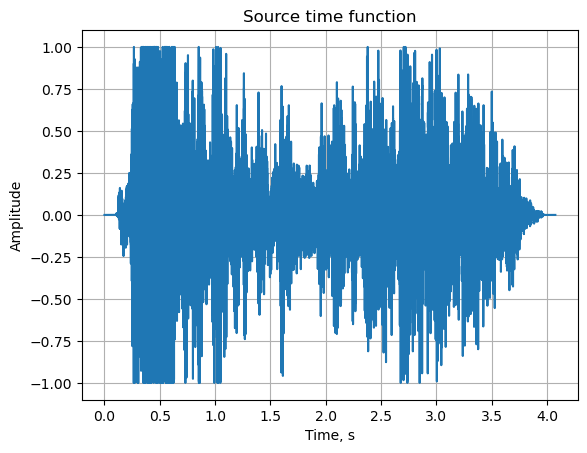

In [3]:
# Plotting of source time function
plt.plot(time_src,thunder)
plt.title('Source time function')
plt.xlabel('Time, s')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

... 并通过将numpy-array转换回声音文件来检查声音文件是否正确导入:

In [4]:
Audio(thunder, rate=rate)

## 三维声学介质中的雷暴

利用数值雷暴的震源子波，我们可以很容易地计算雷声在三维声学介质中的传播. 

让我们回顾下 **三维格林函数** $\mathbf{G_3(x,t;x_s,t_s)}$ 在各向同性的介质中 $V_{p0}$ 由下面的偏微分方程控制:

\begin{equation}
\frac{\partial^2 G_3}{\partial t^2} - V_{p0}^2 \biggl(\frac{\partial^2 G_3}{\partial x^2} + \frac{\partial^2 G_3}{\partial y^2} +\frac{\partial^2 G_3}{\partial z^2} \biggl)= \delta(t-t_s) \delta(x-x_s) \delta(y-y_s) \delta(z-z_s) \nonumber
\end{equation}

这里 $x_s,\;y_s,\;z_s,\;t_s$ 表示震源位置子波和震源时间子波的时空位移. Diracs delta 函数 $\delta(x)$ 定义为 

$$
\delta(x) = \left\{
\begin{array}{ll}
	\infty &x=0 \\
	0 &x\neq 0 	
\end{array}
\right.
$$

解为:

\begin{equation}
G_3(x,y,z,t) = \dfrac{1}{4 \pi V_{p0}^2 r}\delta\biggl((t-t_s)-\frac{r}{V_{p0}}\biggr) \nonumber 
\end{equation}

震源-接收器之间的距离 (offset)

$r = \sqrt{(x-x_s)^2+(y-y_s)^2+(z-z_s)^2}$

因此，均匀声学介质的三维格林函数是一个Delta分布，它被震源和接收器之间的旅行时间延迟，并且与偏移量成比例。

为了计算地震图 $G_{seis}(x,t)$ 对于任意震源子波, 我们不得不把格林函数 $G(x,t;x_s,t_s)$ 卷积上震源子波 $s(t)$ 得到:

$$G_{seis}(x,t) = G(x,t;x_s,t_s) * s(t)$$


在下面的函数中, 我编译了三维格林函数的计算和给定偏移量的地震图计算 `xr`, 最长纪录时间 `tmax`, 时间点个数 `nt` 和震源子波, 在这个例子中，雷电传播的速度为声速 (vp0 = 333 m/s). 

In [13]:
def calc_seis_3D(xr,tmax,nt,thunder):

    # Define P-wave velocity of air (m/s)
    vp0 = 333.

    # Acquisition geometry
    ts = 0                  # source time
    
    xs = 0                  # source position
    ys = 0
    zs = 0
    
    yr = 0                  # receiver position
    zr = 0 
    
    # Computation of 3D Green's function
    G3=np.zeros(nt)                                # initialization G with zeros
    r=np.sqrt((xs-xr)**2+(ys-yr)**2+(zs-zr)**2)   # defining offset
    amp = 1./(4*np.pi*(vp0**2)*r)                 # defining amplitudes
    t_arr=ts+(r/vp0)                              # time arrival
    i_arr=t_arr/dt
    b=int(i_arr)
    G3[b]= amp/dt
    
    # Computation of seismograms for given source wavelet
    seis = np.convolve(G3,thunder)
    seis = seis[0:nt]

    return seis    

定义最大地震记录时间后 `tmax` 作为最大源时间的乘法器 `tmax_src`, 我们可以分别计算在1公里和0公里偏移处的最终地震记录和地震记录的“时间”向量。 因为3D Green的函数在0 km的偏移处变成了奇异值，我们用一个小的值如1 m来代替偏移

In [14]:
# maximum seismogram recording time
tmax = 2.0 * tmax_src   

# Define time vector
time = np.arange(0,tmax,dt)
nt = len(time)

# calculate seismograms at 0 km and 1 km offset
G3_seis_1m = calc_seis_3D(1.0,tmax,nt,thunder)
G3_seis_1km = calc_seis_3D(1000.0,tmax,nt,thunder)

The visualization of the resulting seismograms at 0 km offset ...

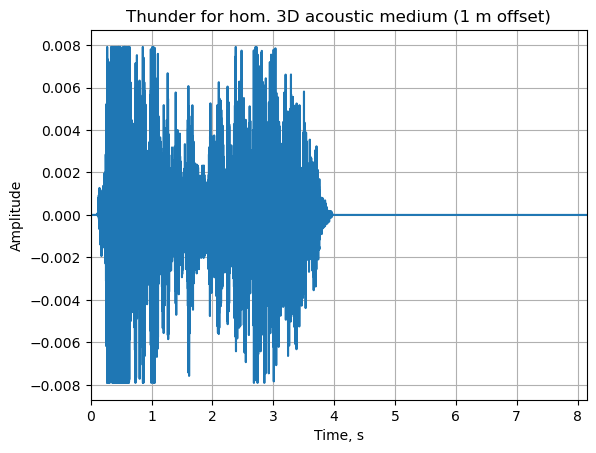

In [15]:
# Plotting Seismogram at 1 m offset
plt.plot(time, G3_seis_1m)
plt.title("Thunder for hom. 3D acoustic medium (1 m offset)" )
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.xlim((0, tmax))
plt.grid()
plt.show()

... and 1 km offset ...

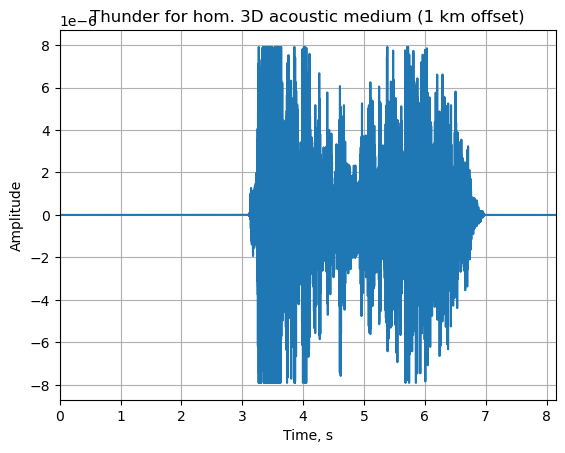

In [16]:
# Plotting Seismogram at 1 km offset
plt.plot(time, G3_seis_1km)
plt.title("Thunder for hom. 3D acoustic medium (1 km offset)" )
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.xlim((0, tmax))
plt.grid()
plt.show()

... 揭示雷源小波的时移3 s。这与基本规则是一致的，即你可以通过计算闪电到达和雷声之间的秒数来计算到闪电的距离。每3秒对应大约1公里的距离。

通过听地震记录来检查这条规则。闪光的外观不像在自然界中那样令人印象深刻。在这种情况下，它对应于点击鼠标的播放按钮。

如果你坐在外面拿着笔记本电脑，那么距离1米就意味着你最有可能被闪电击中，你应该注意到闪电和雷声之间没有延时:

In [17]:
Audio(G3_seis_1m, rate=rate)

如果你距离闪光1公里，你应该，根据你计算1秒的准确性，估计3秒的时间延迟

In [18]:
Audio(G3_seis_1km, rate=rate)

正如我在课堂上提到过的:简单的理论物理能够预测未来。

虽然时间延迟的描述是正确的, the `Audio` 函数似乎没有正确地再现雷声的振幅衰减由于 **三维几何扩散**. 这个问题的原因很可能是由于地震记录的标准化, 在 `Audio` 功能播放之前. 

我们可以通过在1公里偏移处的地震图上增加一个1米偏移处的最大振幅的峰值来修正相对振幅的行为。

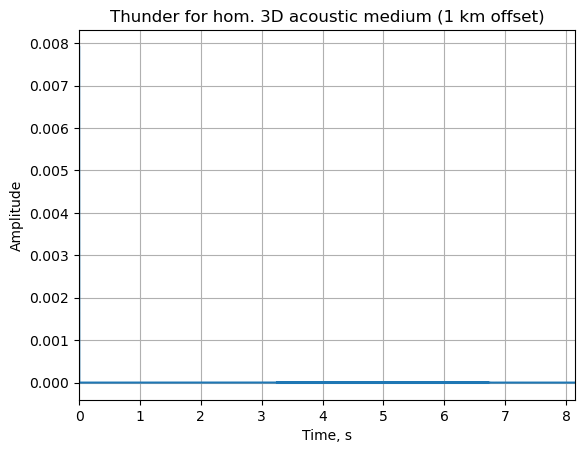

In [19]:
# Estimate maximum amplitude seismogram at 1 m offset
amp_max_1m = np.amax(G3_seis_1m)

# Add spike at first time sample of seismogram at 1 km 
# offset with maximum amplitude amp_max_0km
G3_seis_1km[0] = amp_max_1m

plt.plot(time, G3_seis_1km)
plt.title("Thunder for hom. 3D acoustic medium (1 km offset)" )
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.xlim((0, tmax))
plt.grid()
plt.show()

哇，注意到振幅衰减由于几何扩散超过1公里的距离是相当显著的。我们几乎看不出雷声的小波。要听到雷声，你必须把扬声器的音量调到最大 **(别忘了在打开下一个笔记本后把它调回来)**.

In [21]:
Audio(G3_seis_1km, rate=rate)

为了在1公里外听到雷声，震源的振幅必须相当大。

## 一维声学介质中的雷暴

与三维介质相似, 我们描述 **一维格林函数** $\mathbf{G_1(x,t;x_s,t_s)}$ 对于具有恒定p波速度的均匀一维声波介质 $V_{p0}$ 用偏微分方程:

\begin{equation}
\frac{\partial^2 G_1}{\partial t^2} - V_{p0}^2 \frac{\partial^2 G_1}{\partial x^2} = \delta(t-t_s) \delta(x-x_s)
\notag
\end{equation}

解为:

\begin{equation}
G_1(x,t)=\dfrac{1}{2V_{p0}}H\biggl((t-t_s)-\dfrac{|x-x_s|}{V_{p0}}\biggr),\nonumber
\nonumber 
\end{equation}

利用 Heaviside 函数

$$
H(x) = \left\{
\begin{array}{ll}
	0 &x<0 \\
	1 &x\geq 0 	
\end{array}
\right.
$$

因此，一维格林函数对于均匀声介质基本上是一个被源和接收器之间的旅行时间延迟的Heaviside分布。

类似于三维声波介质，我们可以写一个函数来计算均匀一维声波介质中的地震图:

In [22]:
def calc_seis_1D(xr,tmax,nt,thunder):

    # Define P-wave velocity of air (m/s)
    vp0 = 333.

    # Acquisition geometry
    ts = 0                  # source time shift
    xs = 0                  # spatial source shift
    
    # Computation of 1D Green's function 
    G1=np.zeros(nt)                                # initialization G with zeros
    for i in range (nt):
        
        if (((time[i]-ts)-abs(xr-xs)/vp0)>=0):
            G1[i]=1./(2*vp0)
        else:
            G1[i]=0
    
    # Computation of seismograms for given source wavelet
    G1_seis = np.convolve(G1,thunder)
    G1_seis = G1_seis[0:nt]

    return G1_seis    

0公里和1公里的地震记录的计算和可视化揭示 ...

In [25]:
# maximum seismogram recording time
tmax = 2.0 * tmax_src   

# Define time vector
time = np.arange(0,tmax,dt)
nt = len(time)

# calculate seismograms at 1 m and 1 km offset
G1_seis_1m = calc_seis_1D(1.0,tmax,nt,thunder)
G1_seis_1km = calc_seis_1D(1000.0,tmax,nt,thunder)

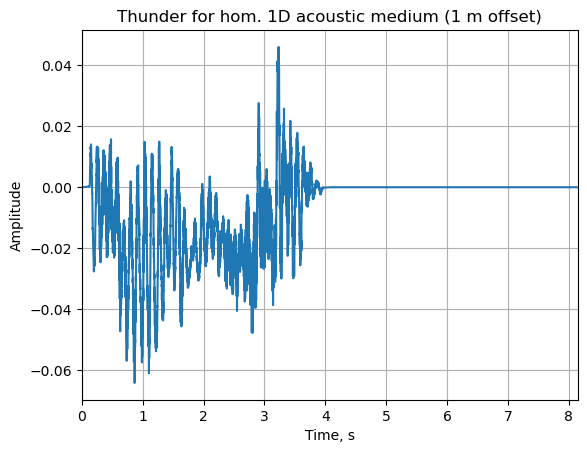

In [26]:
# Plotting Seismogram at 1 m offset
plt.plot(time, G1_seis_1m)
plt.title("Thunder for hom. 1D acoustic medium (1 m offset)" )
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.xlim((0, tmax))
plt.grid()
plt.show()

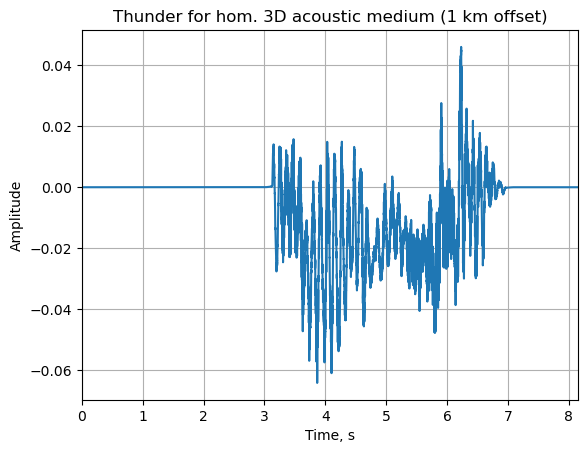

In [27]:
# Plotting Seismogram at 1 km offset
plt.plot(time, G1_seis_1km)
plt.title("Thunder for hom. 3D acoustic medium (1 km offset)" )
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.xlim((0, tmax))
plt.grid()
plt.show()

... 由于一维声波介质的小波积分特性，形成了截然不同的波形。让我们来听听1D雷声在1米偏移处的声音

In [28]:
Audio(G1_seis_1m, rate=rate)

与3D雷电相比

In [29]:
Audio(G3_seis_1m, rate=rate)

注意，由于地震子波积分在一维波传播过程中的低通滤波特性，一维地震记录的高频内容似乎被抑制了。当波形发生变化时，一维介质中的延时与三维介质中的延时保持一致。在1公里的偏移处，闪电和雷声之间仍然有3秒的时间差

In [31]:
Audio(G1_seis_1km, rate=rate)

与3D介质类似，我们可以将相对振幅差归一化，方法是在距离1公里处的地震记录时间序列的第一个样本上添加一个距1米处地震记录振幅最大的峰值。

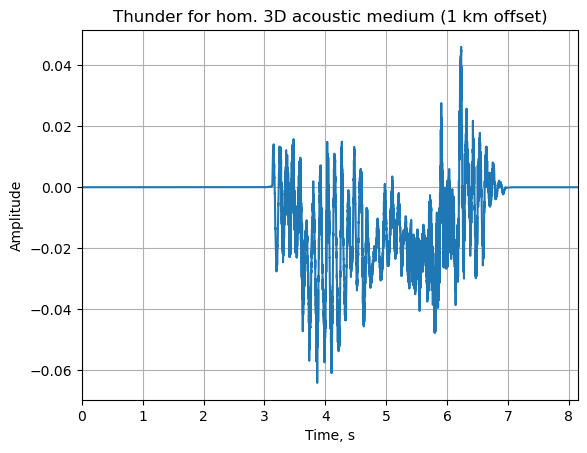

In [32]:
# Estimate maximum amplitude seismogram at 1 m offset
amp_max_1m = np.max(G1_seis_1m)

# Add spike at first time sample of seismogram at 1 km 
# offset with maximum amplitude amp_max_0km
G1_seis_1km[0] = amp_max_1m

plt.plot(time, G1_seis_1km)
plt.title("Thunder for hom. 3D acoustic medium (1 km offset)" )
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.xlim((0, tmax))
plt.grid()
plt.show()

由于“在一维介质中缺乏几何传播”，在1公里偏移处得到的地震记录与在零偏移处得到的地震记录具有相同的振幅。听1米偏移的录音

In [33]:
Audio(G1_seis_1m, rate=rate)

and 1 km offset with correct relative amplitudes

In [34]:
Audio(G1_seis_1km, rate=rate)

## 我们学习到:

* 如何将波文件导入Python
* 如何在扬声器上“播放”numpy-数组
* 雷源小波在均匀声波介质中传播的三维解析地震图描述了闪电和雷声在任意偏移处之间的正确时延。显然，我们假设了均匀介质，忽略了任何回声
* 几何扩展引起的三维振幅衰减非常显著
* 声波在一维声波介质中的传播不同于三维声波介质，由于 ...

... 缺乏几何扩展。因此，一维宇宙中的每一个低语在一维宇宙的任何地方都可以听到

... 一维波传播过程中的波形积分充当低通滤波器，因此抑制了源小波的高频内容